This notebook was written by Maxime Talarmain and Olivier Randavel

This notebook gathers several computer visions technik in order to classified pictures. Experiments will go throught image augmentation, custom models and transfert learning using state of the art pretrained models. A seed has been specified that the user can train the model by himself and find the same results.


The data used come from [link](https://zindi.africa/hackathons/spot-the-mask-challenge/data) and can be found in the [git](https://github.com/Olivierrd/IASD_master/tree/master/Computer%20Vision)


The summary goes as follow : 

![summary](https://docs.google.com/uc?export=download&id=18EkR-OxSbma7zl2NdYc9JtEUDrsZplY4)

The two first parts involved two different data preprocessing and evaluate the same data throught several models. The third part compares all implementations. Finally we create a tool box in the last part that gathers some other interesting implémentations.



#Connection to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from datetime import datetime

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy.random import seed
seed(1)
import pandas as pd
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


#Confusion matrix 

This metric will be used to evaluate our models

In [ ]:
def conf_matrix(model, X_test, Y_test):
  pred=model.predict(X_test, verbose=1)
  y_pred = np.argmax(pred,axis=1)
  conf_mat=confusion_matrix([np.argmax(i) for i in Y_test], y_pred)
  print('Confusion Matrix :')
  print(conf_mat)
  print("accuracy :")
  print((conf_mat[0,0]+conf_mat[1,1])/(conf_mat.sum()))

#Initialize TensorBoard

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir /content/drive/My\ Drive/Dauphine/Semestre\ 2/Traitement\ d\'image\ apprentissage\ profond\ /Projet/logs

<IPython.core.display.Javascript object>

# I/ Data Loading

We construct a dictionnary that contains all pictures' directories

In [ ]:
import os
PATH_1 =  "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/Masque"
id_to_path_masque = {str(count) : PATH_1  + "/" + img
                 for img,count in zip(sorted(os.listdir(PATH_1)),range(len(sorted(os.listdir(PATH_1)))))}

PATH_2 =  "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/NoMasque"
id_to_path_no_masque = {str(count) : PATH_2  + "/" + img
                 for img,count in zip(sorted(os.listdir(PATH_2)),range(len(sorted(os.listdir(PATH_1))), len(sorted(os.listdir(PATH_1)))+len(sorted(os.listdir(PATH_2)))))}

id_to_path = dict(id_to_path_masque, **id_to_path_no_masque)
len(id_to_path), len(id_to_path_no_masque), len(id_to_path_masque)

(1308, 664, 644)

##Load Data

To load the data we use threads. It makes the loading asynchronous and quicker than classical iterative loop

In [ ]:
import concurrent.futures
import time
import urllib.request
from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm
import numpy as np
import random

def start_asynchronous_limit(id_to_path, augmented=False, size=60) :
  limit = 700
  start = time.time()

  # Retrieve a single page and report the URL and contents
  def resize100(img, augmented, size):
    if augmented :
      h,w = img.size
      if w<800 and h<800 :
        new_size = (900, 900)
        new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
        new_im.paste(old_im, ((new_size[0]-old_size[0])//2,
                              (new_size[1]-old_size[1])//2))
        return(new_im)
    else : 
      if size == 60 : 
        return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]
      if size == 100 : 
        return resize(img, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)
  
  def request(num,path, augmented, size):
    try : 
      #print(str(num) +" has started")
      t = np.expand_dims(resize100(imread(path), augmented, size),0)
      #print(str(num) +" has finished")
      return t,int(num)

    except Exception as e : 
      pass 
      print(e)

  all_imgs = []
  index = []

  with concurrent.futures.ThreadPoolExecutor(max_workers=limit) as executor:
      futures = {executor.submit(request, num, path, augmented, size): path for path,num in zip(id_to_path.values(),id_to_path.keys())}
      futures, _ = concurrent.futures.wait(futures)
      for future in futures:
          i = future.result()
          all_imgs += [i[0]]
          index += [i[1]]

  d={}
  for i,j in zip(index,range(len(index))) : 
    d[i] = all_imgs[j]
  d = { i : d[i] for i in sorted([*d])}
  all_imgs = [d[i] for i in [*d]]
  index = [i for i in [*d]]
  all_imgs = np.vstack(all_imgs)
  print(f'Executed in {round(time.time()-start, 2)} seconds')
  return all_imgs,  index

In [ ]:
all_imgs,  index = start_asynchronous_limit(id_to_path, False)
print(all_imgs.shape, index[:10])
print("The data is stored in the memory and uses "+ str(round(all_imgs.nbytes / 1e6, 0)) + " MB")

Executed in 157.57 seconds
(1308, 60, 60, 3) [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
The data is stored in the memory and uses 113.0 MB


##Construct Test and Train set

In [ ]:
def build_train_test_data(id_to_path, split=0.9):
    X1_ids_train, Y_ids_train, X1_ids_test, Y_ids_test, name= [], [], [], [], []
    keys = [*id_to_path]
    random.shuffle(keys)
    for i, count in zip(keys, range(len(keys))) : 
      name.append(id_to_path[i])
      if count/len(keys) < split : 
        if "NoMasque" in id_to_path[i] : 
          X1_ids_train.append(i)
          Y_ids_train.append(0)
        else : 
          X1_ids_train.append(i)
          Y_ids_train.append(1)
      else :
        if "NoMasque" in id_to_path[i] : 
          X1_ids_test.append(i)
          Y_ids_test.append(0)
        else : 
          X1_ids_test.append(i)
          Y_ids_test.append(1)   
    return name, X1_ids_train, Y_ids_train, X1_ids_test,Y_ids_test

name, X1_ids_train, Y_ids_train, X1_ids_test, Y_ids_test = build_train_test_data(id_to_path)

In [ ]:
from imgaug import augmenters as iaa
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    import tensorflow as tf

seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    # You can add more transformation like random rotations, random change of luminance, etc.
])

class Generator(tf.keras.utils.Sequence):

    def __init__(self, X1, Y, batch_size, all_imgs):
        self.batch_size = batch_size
        self.X1 = X1
        self.Y = Y
        self.imgs = all_imgs
        self.num_samples = len(Y)
        
    def __len__(self):
        return self.num_samples // self.batch_size
        
    def __getitem__(self, batch_index):
        """This method returns the `batch_index`-th batch of the dataset.
        
        Keras choose by itself the order in which batches are created, and several may be created
        in the same time using multiprocessing. Therefore, avoid any side-effect in this method!
        """
        low_index = batch_index * self.batch_size
        high_index = (batch_index + 1) * self.batch_size
        t= [int(i) for i in self.X1[low_index:high_index]]
        imgs1 = seq.augment_images(self.imgs[t])
        targets = self.Y[low_index:high_index]
    
        return (imgs1, targets)

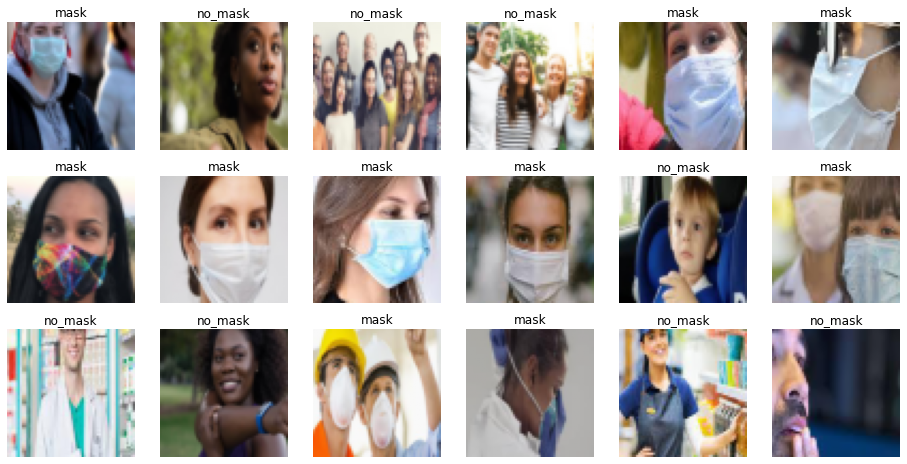

In [ ]:
import matplotlib.pyplot as plt
# The functionnality of the generator is not used as the 1400 pictures can be stocked in ram
gen = Generator(X1_ids_train, Y_ids_train, 1400, all_imgs) 
x1, y = gen[0]


plt.figure(figsize=(16, 8))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(x1[i] / 255)
    if y[i]==1:
        plt.title("mask")
    else:
        plt.title("no_mask")
    plt.axis('off')
    
plt.show()

In [ ]:
gen = Generator(X1_ids_train, Y_ids_train, 1400, all_imgs)
x_train, y_train = gen[0]
gen = Generator(X1_ids_test, Y_ids_test, 1400, all_imgs)
x_test, y_test = gen[0]
input_shape=x_train[0].shape

train_labels_encoded = tf.keras.utils.to_categorical(y_train)
test_labels_encoded = tf.keras.utils.to_categorical(y_test)
def normalize(train_images, test_images):
	train_norm = train_images.astype('float32') / 255.0
	test_norm = test_images.astype('float32') / 255.0
	return train_norm, test_norm

train_images, test_images = normalize(x_train, x_test)

category_size=train_labels_encoded.shape[1]

#Build Model

##Simple

In [ ]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D

def conv_block(filter_size_, kernel_size_=3, max_pooling_size_=2, activation_type_=None, input_shape_=None, seed=42): 
  np.random.seed(seed)
  tf.random.set_seed(seed)
  model_ = tf.keras.Sequential()
  model_.seed = seed
  model_.add(Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, input_shape=input_shape_, padding='same'))
  model_.add(MaxPooling2D(max_pooling_size_))
  model_.add(Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, input_shape=input_shape_, padding='same'))
  model_.add(MaxPooling2D(max_pooling_size_))
  return model_

model = conv_block(32, (3, 3), (2, 2), activation_type_='relu', input_shape_=input_shape)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(category_size, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
Path_to_save = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/logs"
logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_simple")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#### Fit your model (you can use the test set as your validation data)
history = model.fit(train_images, train_labels_encoded, epochs=50, batch_size=64,
                    validation_data=(test_images, test_labels_encoded), callbacks=[tensorboard_callback] )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               921728    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
conf_matrix(model, test_images, test_labels_encoded)

5/5 [==============================] - 0s 3ms/step
Confusion Matrix :
[[52 11]
 [36 31]]
accuracy :
0.6384615384615384


##Second

In [ ]:
#### Create a basic model made of a convolutional bloc (e.g., at least one convolutional layer followed by a maxpooling layer)
def conv_block(filter_size_, kernel_size_, max_pooling_size_, activation_type_=None, input_shape_=None, seed=42):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  model_ = tf.keras.Sequential()
  model_.seed = seed
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, input_shape=input_shape_, padding='same'))
  model_.add(tf.keras.layers.Conv2D(filters=filter_size_, kernel_size=kernel_size_, activation=activation_type_, padding='same'))
  model_.add(tf.keras.layers.MaxPooling2D(max_pooling_size_))
  return model_

category_size=train_labels_encoded.shape[1]

model = conv_block(32, 5, 3, 'relu', input_shape_=input_shape)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(category_size, activation='sigmoid'))
model.compile(tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      width_shift_range=0.1, height_shift_range=0.1,
      horizontal_flip=True, zoom_range=0.1)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)

Path_to_save = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/logs"
logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_second")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

#### Fit your model (you can use the test set as your validation data)
epochs = 50
if augment_data:
  steps = int(train_images.shape[0] / 64)
  history = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, 
                      validation_data=(test_images, test_labels_encoded), verbose=1, callbacks=[tensorboard_callback])
else:
  history = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded), callbacks=[tensorboard_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 60, 60, 32)        2432      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 60, 32)        25632     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 25602     
Total params: 53,666
Trainable params: 53,666
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
18/18 [==============================] - 2s 111ms/step - loss: 0.6953 - accuracy: 0.4883 - val_loss: 0.69

In [ ]:
conf_matrix(model, test_images, test_labels_encoded)

5/5 [==============================] - 0s 5ms/step
Confusion Matrix :
[[43 20]
 [19 48]]
accuracy :
0.7


##Transfert learning 

###VGG

In [ ]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape=(train_images.shape[1],train_images.shape[2],train_images.shape[3]))
base_model.trainable = True

top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dropout(0.5))
top_layers.add(tf.keras.layers.Dense(2,activation='sigmoid'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])
epochs = 50
opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
Path_to_save = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/logs"

print("Training without Augmented Data")
logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_VGG_Imagnet_noAD")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
HIST = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                  validation_data=(test_images, test_labels_encoded), callbacks=[tensorboard_callback])

58892288/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential (Sequential)      (None, 2)                 3074      
Total params: 14,717,762
Trainable params: 14,716,738
Non-trainable params: 1,024
_________________________________________________________________
Training without Augmented Data
Epoch 1/50
19/19 [==============================] - 7s 384ms/step - loss: 0.6601 - accuracy: 0.6307 - val_loss: 7.3151 - val_accuracy: 0.5462
Epoch 2/50
19/19 [==============================] - 5s 262ms/step - loss: 0.4880 - accuracy: 0.7649 - val_loss: 5.7032 - val_accuracy: 0.5385
Epoch 3/50
19/19 [==============================] - 5s 261ms/step - loss: 0.4128 - accuracy: 0.8149 - val_loss: 6.7450 

In [ ]:
conf_matrix(model, test_images, test_labels_encoded)

5/5 [==============================] - 0s 29ms/step
Confusion Matrix :
[[67  4]
 [ 7 52]]
accuracy :
0.9153846153846154


In [ ]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape=(train_images.shape[1],train_images.shape[2],train_images.shape[3]))
base_model.trainable = True

top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dropout(0.5))
top_layers.add(tf.keras.layers.Dense(2,activation='sigmoid'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])
opt = tf.keras.optimizers.SGD(lr=0.005, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, rotation_range=30, zoom_range=0.3, height_shift_range=0.2, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)
epochs = 50
Path_to_save = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/logs"


if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_VGG_Imagnet_AD")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  HIST = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1, callbacks=[tensorboard_callback])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 3074      
Total params: 14,717,762
Trainable params: 14,716,738
Non-trainable params: 1,024
_________________________________________________________________
Training with Augmented Data
Epoch 1/50
18/18 [==============================] - 5s 298ms/step - loss: 0.6942 - accuracy: 0.5763 - val_loss: 8.3070 - val_accuracy: 0.4846
Epoch 2/50
18/18 [==============================] - 5s 271ms/step - loss: 0.6770 - accuracy: 0.5682 - val_loss: 8.3070 - val_accuracy: 0.4846
Epoch 3/50
18/18 [==============================] - 5s 272ms/step - loss: 0.6423 - accuracy: 0.6463 - val_loss: 8.3070 - val_accuracy: 0.4846
Epoch 4/50
18/18 [===========================

In [ ]:
conf_matrix(model, test_images, test_labels_encoded)

5/5 [==============================] - 0s 29ms/step
Confusion Matrix :
[[34 29]
 [ 0 67]]
accuracy :
0.7769230769230769


### Mobile Net

In [ ]:
base_model=tf.keras.applications.MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
preds=tf.keras.layers.Dense(2,activation='sigmoid')(x) #final layer with softmax activation
epochs = 50
model.summary()
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)
model.compile(tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

Path_to_save = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/logs"

logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_MN_noAD")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
HIST = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                    validation_data=(test_images, test_labels_encoded),
                    callbacks=[tensorboard_callback])

17227776/17225924 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
sequential_4 (Sequential)    (None, 2)                 3074      
Total params: 14,717,762
Trainable params: 14,716,738
Non-trainable params: 1,024
_________________________________________________________________
Epoch 1/50
19/19 [==============================] - 4s 202ms/step - loss: 0.6875 - accuracy: 0.5416 - val_loss: 0.6911 - val_accuracy: 0.6231
Epoch 2/50
19/19 [==============================] - 2s 105ms/step - loss: 0.5468 - accuracy: 0.7156 - val_loss: 0.6914 - val_accuracy: 0.4846
Epoch 3/50
19/19 [==============================] - 2s 102ms/step - loss: 0.3341 - accuracy: 0.8667 - val_loss: 0.6841 - val_accuracy: 0.5462
Epoch 4/5

In [ ]:
conf_matrix(model, test_images, test_labels_encoded)

5/5 [==============================] - 0s 9ms/step
Confusion Matrix :
[[56  7]
 [19 48]]
accuracy :
0.8


### Resnet Inception

In [ ]:
#Image shape must be greater than 75*75
all_imgs,  index = start_asynchronous_limit(id_to_path, False, 100)
gen = Generator(X1_ids_train, Y_ids_train, 1400, all_imgs)
x_train, y_train = gen[0]
gen = Generator(X1_ids_test, Y_ids_test, 1400, all_imgs)
x_test, y_test = gen[0]

train_labels_encoded = tf.keras.utils.to_categorical(y_train)
test_labels_encoded = tf.keras.utils.to_categorical(y_test)
def normalize(train_images, test_images):
	train_norm = train_images.astype('float32') / 255.0
	test_norm = test_images.astype('float32') / 255.0
	return train_norm, test_norm

train_images, test_images = normalize(x_train, x_test)
category_size=train_labels_encoded.shape[1]

Executed in 147.59 seconds


In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(weights= 'imagenet', include_top=False, input_shape=(train_images.shape[1],train_images.shape[2],train_images.shape[3]))
base_model.trainable = False

top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Dense(512))
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dense(16))
top_layers.add(tf.keras.layers.Dropout(0.5))
top_layers.add(tf.keras.layers.Dense(2,activation='sigmoid'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])
model.compile(tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

augment_data=True
if augment_data:
  datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.2, rotation_range=30, zoom_range=0.3, height_shift_range=0.2, horizontal_flip=True)
  it_train = datagen.flow(train_images, train_labels_encoded, batch_size=64)
  #### Fit your model (you can use the test set as your validation data)
epochs = 50
Path_to_save = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/logs"


if augment_data:
  print("Training with Augmented Data")
  steps = int(train_images.shape[0] / 64)
  logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_InceptionResNetV2_AD")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  HIST = model.fit(it_train, steps_per_epoch=steps, epochs=epochs, validation_data=(test_images, test_labels_encoded), verbose=1, callbacks=[tensorboard_callback])

219062272/219055592 [==============================] - 6s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
sequential_6 (Sequential)    (None, 2)                 797234    
Total params: 55,133,970
Trainable params: 796,210
Non-trainable params: 54,337,760
_________________________________________________________________
Training with Augmented Data
Epoch 1/50
18/18 [==============================] - 17s 965ms/step - loss: 0.9422 - accuracy: 0.5512 - val_loss: 0.9553 - val_accuracy: 0.6308
Epoch 2/50
18/18 [==============================] - 10s 569ms/step - loss: 0.7987 - accuracy: 0.6319 - val_loss: 0.5942 - val_accuracy: 0.7154
Epoch 3/50
18/18 [==============================] - 10s 575ms/step - loss: 0.6969 - accuracy: 0.6750 - val_loss: 0.5

In [ ]:
conf_matrix(model, test_images, test_labels_encoded)

5/5 [==============================] - 1s 110ms/step
Confusion Matrix :
[[54  9]
 [15 52]]
accuracy :
0.8153846153846154


In [ ]:
print("Training withOUT Augmented Data")
epochs = 50
base_model = tf.keras.applications.InceptionResNetV2(weights= 'imagenet', include_top=False, input_shape=(train_images.shape[1],train_images.shape[2],train_images.shape[3]))
base_model.trainable = False

top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Dense(512))
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dense(16))
top_layers.add(tf.keras.layers.Dropout(0.5))
top_layers.add(tf.keras.layers.Dense(2,activation='sigmoid'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])
model.compile(tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()
logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_InceptionResNetV2_noAD")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
HIST = model.fit(train_images, train_labels_encoded, epochs=epochs, batch_size=64, 
                  validation_data=(test_images, test_labels_encoded), callbacks=[tensorboard_callback])

Training withOUT Augmented Data
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 1, 1, 1536)        54336736  
_________________________________________________________________
sequential_8 (Sequential)    (None, 2)                 797234    
Total params: 55,133,970
Trainable params: 796,210
Non-trainable params: 54,337,760
_________________________________________________________________
Epoch 1/50
19/19 [==============================] - 15s 787ms/step - loss: 0.7886 - accuracy: 0.6036 - val_loss: 0.8781 - val_accuracy: 0.5846
Epoch 2/50
19/19 [==============================] - 10s 528ms/step - loss: 0.6079 - accuracy: 0.7292 - val_loss: 0.5291 - val_accuracy: 0.7846
Epoch 3/50
19/19 [==============================] - 9s 500ms/step - loss: 0.5578 - accuracy: 0.7436 - val_loss: 0.4877 - val_accuracy: 0.7923
Epoch 4/50
19/19 [====================

In [ ]:
conf_matrix(model, test_images, test_labels_encoded)

5/5 [==============================] - 1s 110ms/step
Confusion Matrix :
[[51 12]
 [15 52]]
accuracy :
0.7923076923076923


# II/ Data Loading 

In [ ]:
train_label=pd.read_csv("/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/train_labels.csv")

On s'intéresse à la taille moyenne des images pour que le resize ne déforme pas trop

In [ ]:
import cv2
MM=[]
LM=[]
MNM=[]
LNM=[]
for i in train_label.values :
  if i[1]==1 :
    img=cv2.imread("/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/Masque/"+i[0])
    MM.append(img.shape[0])
    LM.append(img.shape[1])
  if i[1]==0 :
    img=cv2.imread("/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/NoMasque/"+i[0])
    MNM.append(img.shape[0])
    LNM.append(img.shape[1])

print("Mean size of images with a mask : ",np.mean(MM),"x",np.mean(LM))
print("Mean size of images without a mask : ",np.mean(MNM),"x",np.mean(LNM))

Mean size of images with a mask :  479.1723602484472 x 685.7375776397515
Mean size of images without a mask :  417.85692771084337 x 568.2078313253012


### Data Generation

In [ ]:
train_dir="/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/"
img_height,img_width = 450//2,600//2   # resize qui respecte la taille moyenne des images (impossible de garder 450x600 car le training mettrait trop de temps)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.2,
                             zoom_range=0.2,       # Range for random zoom
                             horizontal_flip=True,  # Randomly flip inputs horizontally
                             validation_split=0.2) # set validation split
                           
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    train_dir,
    classes=["Masque","NoMasque"],
    target_size=(img_height, img_width),
    batch_size=batch_size,
    #class_mode='binary',
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(img_height, img_width),
    classes=["Masque","NoMasque"],
    batch_size=batch_size,
    #class_mode='binary',
    subset='validation') # set as validation data

Found 1048 images belonging to 2 classes.
Found 260 images belonging to 2 classes.


In [ ]:
def conf_matrix(model, X_test):
  pred=model.predict(X_test, verbose=1)
  y_pred = np.argmax(pred,axis=1)
  conf_mat=confusion_matrix(X_test.classes, y_pred)
  print('Confusion Matrix :')
  print(conf_mat)
  print("accuracy :")
  print((conf_mat[0,0]+conf_mat[1,1])/(conf_mat.sum()))

# Buil Model

### Mobile Net

In [ ]:
base_model=tf.keras.applications.MobileNet(weights='imagenet', include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=tf.keras.layers.GlobalAveragePooling2D()(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=tf.keras.layers.Dense(1024,activation='relu')(x) #dense layer 2
x=tf.keras.layers.Dense(512,activation='relu')(x) #dense layer 3
preds=tf.keras.layers.Dense(2,activation='sigmoid')(x) #final layer with softmax activation
model=tf.keras.models.Model(inputs=base_model.input,outputs=preds)
model.compile(tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

Path_to_save = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/logs"
model.summary()

print("Training with Data Generation")
logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_MobileNet_AD_V2")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
HIST = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 5, callbacks=[tensorboard_callback])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, None, None, 3)     0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128 

### ResNet InceptionV2

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(weights= 'imagenet', include_top=False, input_shape= (img_height,img_width,3))
base_model.trainable = False

top_layers = tf.keras.Sequential()
top_layers.add(tf.keras.layers.Dense(512))
top_layers.add(tf.keras.layers.Flatten())
top_layers.add(tf.keras.layers.BatchNormalization())
top_layers.add(tf.keras.layers.Dense(16))
top_layers.add(tf.keras.layers.Dropout(0.5))
top_layers.add(tf.keras.layers.Dense(2,activation='sigmoid'))

model= tf.keras.Sequential([
    base_model, 
    top_layers
])
model.compile(tf.keras.optimizers.SGD(lr=0.0005, momentum=0.9),loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()

Path_to_save = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/logs"

print("Training with Data Generation")
logdir = os.path.join(Path_to_save, datetime.now().strftime("%Y%m%d-%H%M%S")+ "_InceptionResNetV2_AD_V2")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
HIST = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = 8, callbacks=[tensorboard_callback])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 5, 8, 1536)        54336736  
_________________________________________________________________
sequential_10 (Sequential)   (None, 2)                 1196594   
Total params: 55,533,330
Trainable params: 1,155,634
Non-trainable params: 54,377,696
_________________________________________________________________
Training with Data Generation
Epoch 1/8
32/32 [==============================] - 52s 2s/step - loss: 0.4203 - accuracy: 0.8248 - val_loss: 0.5412 - val_accuracy: 0.8281
Epoch 2/8
32/32 [==============================] - 47s 1s/step - loss: 0.2017 - accuracy: 0.9213 - val_loss: 0.3352 - val_accuracy: 0.9062
Epoch 3/8
32/32 [==============================] - 46s 1s/step - loss: 0.2008 - accuracy: 0.9380 - val_loss: 0.2333 - val_accuracy: 0.9375
Epoch 4/8
32/32 [==============================]

#III/ Results 

![results](https://docs.google.com/uc?export=download&id=1swxMtsvqEVHgfZ_H-Q3w6cXYrA6vmnHO)

The best model is the one train using MobileNet_AD_V2. The implementation is detailled in the second part.


Implemented models in the first part have been trained using 50 epochs. Most of them suffer of overfitting. We advice to reduce the number of epochs or to try different data preprocessing has shown in the second part.

The second part shows two models with very high accuracy and low loss. This model have been trained using small amount of epoch less than 10 and perform very well on our dataset.

#IV/ Others

In this part we use the model named *VGG16_NoAD : 20200716-211026_VGG_Imagnet_noAD*

## Try with your camera

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


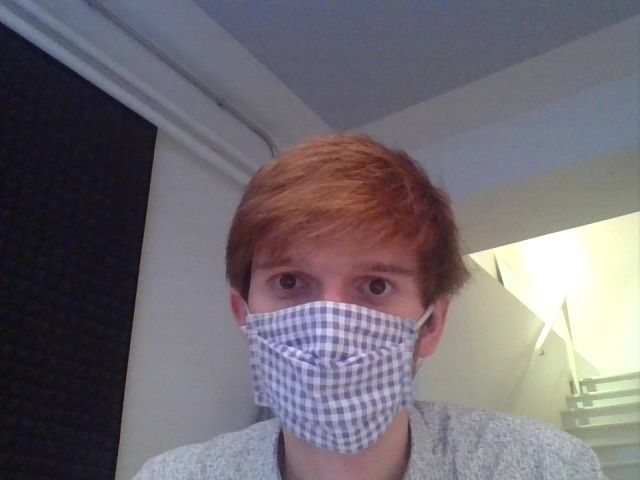

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import matplotlib.image as mpimg
image=mpimg.imread('photo.jpg')
image2 = resize(image, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]
image2 = tf.constant(np.expand_dims(image2, 0), dtype=tf.float32) #expand_dims ajoute une dimension à la position zero
image2 = image2/255.0

print("\n",model.predict(image2))
if np.argmax(model.predict(image2)) == 1 :
  print("\nA mask is displayed on the picture")
else : 
  print("\nNo mask is displayed on the picture")


 [[0.05635013 0.6006237 ]]

A mask is displayed on the picture


<IPython.core.display.Javascript object>

Saved to photo.jpg


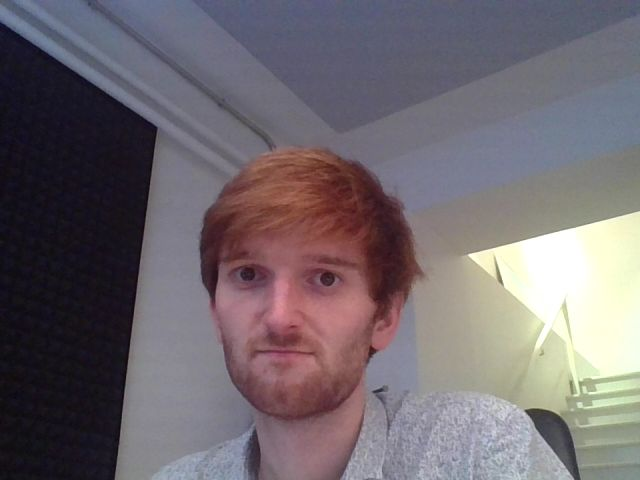

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import matplotlib.image as mpimg
image = mpimg.imread('photo.jpg')
image2 = resize(image, (100, 100), preserve_range=True, mode='reflect', anti_aliasing=True)[20:80,20:80,:]
image2 = tf.constant(np.expand_dims(image2, 0), dtype=tf.float32) #expand_dims ajoute une dimension à la position zero
image2 = image2/255.0
image_y = model.predict(image2)
print("\n", model.predict(image2))
if np.argmax(image_y) == 1 : 
  print("\nA mask is displayed on the picture")
else : 
  print("\nNo mask is displayed on the picture")


 [[9.9961841e-01 1.1777188e-04]]

No mask is displayed on the picture


##Show where decision is taken

In [ ]:
def top_pixels(x_numpy, y_numpy, model=model):
  x = tf.constant(np.expand_dims(x_numpy, 0), dtype=tf.float32) #expand_dims ajoute une dimension à la position zero
    #l'inverse c'est squiz supprime une dimension, same as reshape
  y = tf.expand_dims(tf.constant(train_labels_encoded[0]),0)

  #### YOUR CODE HERE
  with tf.GradientTape() as g:
    g.watch(x)
    prediction = model(x)  # retourne un tensor et predict retourne un array 
    loss_func = tf.keras.losses.CategoricalCrossentropy()
    loss_value = loss_func(y, prediction)

    impact = np.abs(g.gradient(loss_value, x))
  
  q = np.quantile(impact, 0.90)  #permet d'afficher les pixels les pixels les plus impactants. 
  impact[impact<q] = 0
  impact[impact>=q] = 1

  ####

  plt.imshow(x_numpy)
  plt.imshow(np.squeeze(impact, 0), cmap= "winter", alpha=0.4)


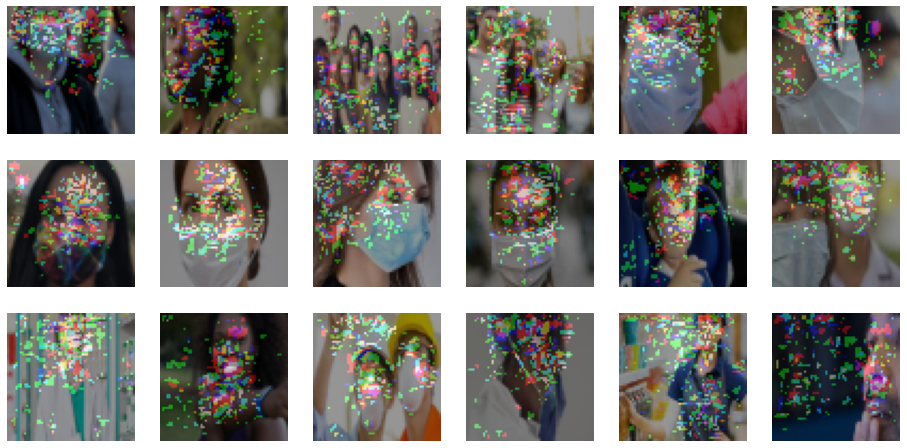

In [ ]:
plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    top_pixels(train_images[i], train_labels_encoded[i])
    plt.axis("off")
plt.show()

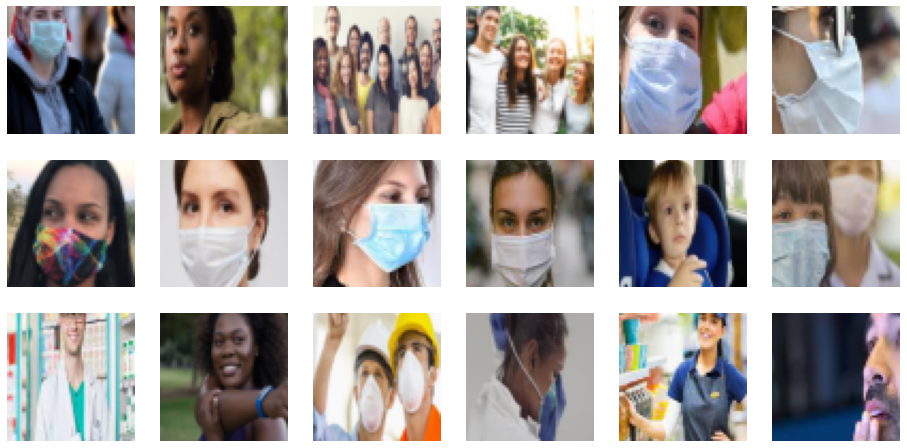

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
for i in range(0, 18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(train_images[i])
    plt.axis('off')
    
plt.show()

## Labelliser Sub data

An unlabeled dataset is given. We use the model to classify the pictures

In [ ]:
# read all directories
import os
PATH_1 =  "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/Sub"
id_to_path_sub = {str(count) : PATH_1  + "/" + img
                 for img,count in zip(sorted(os.listdir(PATH_1)),range(len(sorted(os.listdir(PATH_1)))))}
all_imgs,  index = start_asynchronous_limit(id_to_path_sub) # probleme d'ordre

Executed in 49.48 seconds


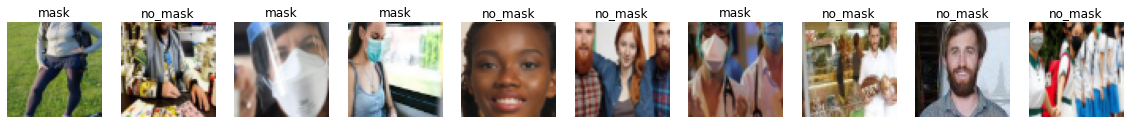

In [ ]:
import matplotlib.pyplot as plt

nbr = 10
plt.figure(figsize=(20, 10))
for i in range(nbr):
    plt.subplot(2, nbr, i + nbr+1)
    plt.imshow(all_imgs[i] / 255)
    y = np.argmax(model.predict(np.expand_dims(all_imgs[i].astype('float32') / 255.0,0)))
    if y==1:
        plt.title("mask")
    else:
        plt.title("no_mask")
    plt.axis('off')
    
plt.show()

In [ ]:
#DELETE ALL FILES 
import shutil
PATH_1 =  "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/Sub model classified/NoMasque"
id_to_path_sub_delete = {str(count) : PATH_1  + "/" + img
                 for img,count in zip(sorted(os.listdir(PATH_1)),range(len(sorted(os.listdir(PATH_1)))))}
for i in id_to_path_sub_delete.values() :
  try : 
    shutil.rmtree(i)
  except : 
    pass

PATH_1 =  "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/Sub model classified/Masque"
id_to_path_sub_delete = {str(count) : PATH_1  + "/" + img
                 for img,count in zip(sorted(os.listdir(PATH_1)),range(len(sorted(os.listdir(PATH_1)))))}
for i in id_to_path_sub_delete.values() :
  try :
    shutil.rmtree(i)
  except : 
    pass

#CLASSIFIED ALL PUCTURES FROM SUB
for i in range(0,len(all_imgs)) :
  y = np.argmax(model.predict(np.expand_dims(all_imgs[i].astype('float32') / 255.0,0)))
  if y ==1 : 
    src_dir = id_to_path_sub[str(i)]
    dst_dir = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/Sub model classified/Masque"
    shutil.copy(src_dir,dst_dir)
  else : 
    src_dir = id_to_path_sub[str(i)]
    dst_dir = "/content/drive/My Drive/Dauphine/Semestre 2/Traitement d'image apprentissage profond /Projet/Data/Sub model classified/NoMasque"
    shutil.copy(src_dir,dst_dir)